In [1]:
import pandas as pd
rna_data = pd.read_csv("gene_data/rna_common_complete.csv")
rna_data = rna_data.sort_values(by=['sn','period']).reset_index(drop=True)

In [2]:
X_og_shape = rna_data.drop(['sn','group','caarms_status','period'],axis=1).values
X_reshaped = X_og_shape.reshape(len(set(rna_data['sn'])), 3, X_og_shape.shape[1])
labels_group = rna_data[rna_data['period'] == 24]['group'].values
labels = [0 if i == 'C' else 1 for i in labels_group]

In [3]:
import torch
from neucube.utils import SNR
from neucube.utils import interpolate

ratios = SNR(X_reshaped[:,0,:], labels)
top_idx = torch.argsort(ratios, descending=True)[0:15]
X_reshaped_topidx = X_reshaped[:,:,top_idx]
interpolated_X = interpolate(X_reshaped_topidx, num_points=104)

In [4]:
from neucube.encoder import Delta
encoder = Delta(threshold=0.01)
X = encoder.encode_dataset(interpolated_X)
y = torch.tensor(labels)

In [5]:
# from neucube.encoder import StepForward
# encoder = StepForward(threshold=0.01)
# X = encoder.encode_dataset(interpolated_X)
# y = torch.tensor(labels)
# X.sum()

In [6]:
from neucube import Reservoir
res = Reservoir(inputs=X.shape[2], c=0.7, l=0.165)
res.summary()

Neurons                1000  
Reservoir connections  20752 
Input connections      736   
Device                 cuda:0


In [7]:
from neucube import IzhReservoir
izh_res = IzhReservoir(inputs=X.shape[2], c=0.5, l=0.165)
izh_res.summary()

Neurons                1000  
Reservoir connections  14899 
Input connections      736   
Device                 cuda:0


In [127]:
#out_spikes = res.simulate(X, mem_thr=0.02, refractory_period=3, train=False)

In [16]:
izh_res.set_exc_parms(a=0.1, b=0.2, c=-55, d=2)
#izh_res.set_exc_parms(a=0.02, b=0.55, c=-45, d=4) #more frequent chattering
izh_res.set_inh_parms(a=0.1, b=0.2, c=-65, d=2)

out_spikes = izh_res.simulate(X, mem_thr=30, train=False, verbose=True)

100%|██████████| 115/115 [00:25<00:00,  4.44it/s]


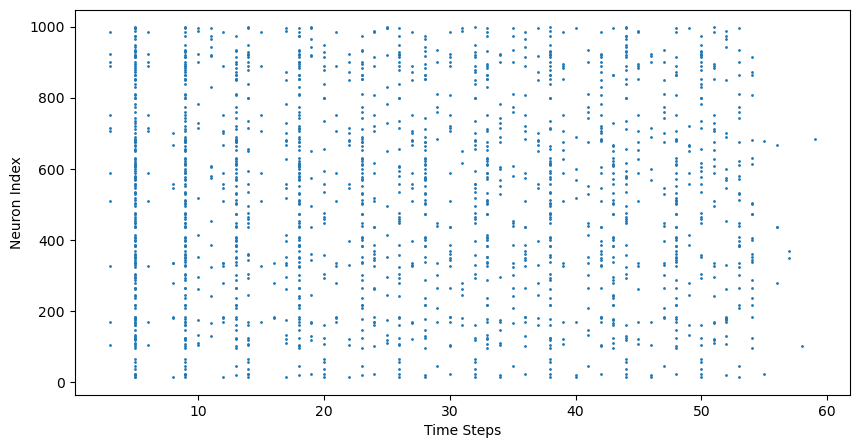

In [17]:
from neucube.visualise import spike_raster
spike_raster(out_spikes[0])

In [20]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from neucube.sampler import SpikeCount, MeanFiringRate, ISIstats, TemporalBinning

#sampler = TemporalBinning(bin_size=10)
sampler = SpikeCount()
state_vec = sampler.sample(out_spikes)
print(state_vec.shape)

# Define the number of folds
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    svm = SVC(kernel='linear', C=3)  # You can specify different kernels ('linear', 'poly', 'rbf', etc.)
    svm.fit(X_train_fold, y_train_fold)
    y_pred = svm.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

torch.Size([115, 100])


0it [00:00, ?it/s]

10it [00:00, 57.45it/s]


10-Fold Cross-Validation Accuracy: 0.7391304347826086
[[48 16]
 [14 37]]


In [19]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from neucube.sampler import SpikeCount

test_X = X_reshaped_topidx.reshape(X_reshaped_topidx.shape[0], X_reshaped_topidx.shape[1]*X_reshaped_topidx.shape[2])

num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(test_X)):
    X_train_fold, X_test_fold = test_X[train_index], test_X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    svm = SVC(kernel='linear', C=2)  # You can specify different kernels ('linear', 'poly', 'rbf', etc.)
    svm.fit(X_train_fold, y_train_fold)
    y_pred = svm.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

10it [00:00, 162.08it/s]

10-Fold Cross-Validation Accuracy: 0.782608695652174
[[52 12]
 [13 38]]
